In [1]:
"""
@author: Dhruv Parikh, Anirudh Kailaje
@date: 7th Nov 2023
@file: bipedSquat.py
@brief: Biped Does a Squat!
Mathematically: We track the Center of Mass trajectory on z direction with constraints of both foot on ground
"""
import pydot
import numpy as np

from pydrake.all import Simulator, DiagramBuilder, AddMultibodyPlantSceneGraph,\
                        Parser, RigidTransform, MeshcatVisualizer, MeshcatVisualizerParams, \
                        ConstantVectorSource, ConstantValueSource, PiecewisePolynomial,\
                        AbstractValue, HalfSpace, CoulombFriction
import planner
from osc import OSC

from pydrake.all import StartMeshcat, BasicVector, LogVectorOutput
import matplotlib.pyplot as plt, datetime



INFO:drake:Meshcat listening for connections at http://localhost:7000


1.9809088823063015


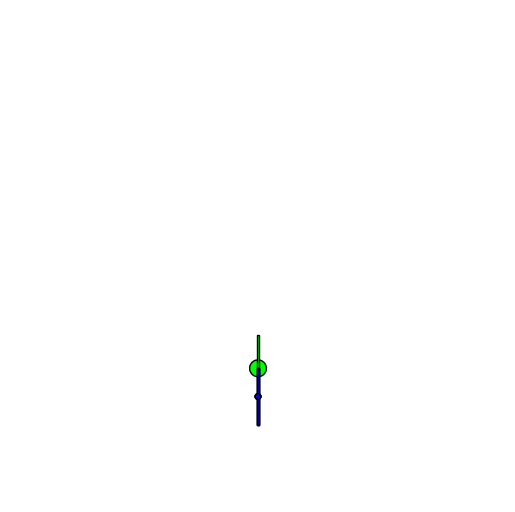

In [2]:
time = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")

#Start the meshcat server
meshcat = StartMeshcat()
builder = DiagramBuilder()

#### Designing our world ####
# Add a planar walker to the simulation
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, 0.001)
#Half space means a plane -> Ground Plane in particular
X_WG = HalfSpace.MakePose(np.array([0,0, 1]), np.zeros(3,))
plant.RegisterCollisionGeometry(
    plant.world_body(), 
    X_WG, HalfSpace(), 
    "collision", CoulombFriction(1.0, 1.0))

#Make the plant
urdf = r"/home/dhruv/Hop-Skip-and-Jump/models/planar_walker.urdf"
parser = Parser(plant)
parser.AddModels(urdf)
plant.WeldFrames(
    plant.world_frame(),
    plant.GetBodyByName("base").body_frame(),
    RigidTransform.Identity()
)
plant.Finalize()


#### Designing the controller ####
"""
Here,
zdes: desired squat Z height in meters
z_height_desired: A constant source which outputs the desired Z height, given to the com_planner
com_planner: A controller which tracks the desired Z height for the center of mass
base_traj_src: A constant source which outputs a constant vector (No movement in the Y direction for the robot), given to the osc
osc: The operational space controller which tracks the desired Z height and the base_traj_src
"""
zdes = np.sqrt(2*9.81*0.2)
print(zdes)

# zdes = 12 #desired Z height in meters
z_height_desired = builder.AddSystem(ConstantVectorSource(np.array([zdes])))
com_planner = builder.AddSystem(planner.COMPlanner())
base_traj_src = builder.AddSystem(ConstantValueSource(AbstractValue.Make(BasicVector(np.zeros(1,)))))
osc_accessor = OSC(urdf)
osc = builder.AddSystem(osc_accessor)

#### Wiring ####
#COM wiring
builder.Connect(z_height_desired.get_output_port(), com_planner.get_com_zdes_input_port())
builder.Connect(plant.get_state_output_port(), com_planner.get_com_state_input_port())
# OSC wiring
builder.Connect(com_planner.get_com_traj_output_port(), osc.get_traj_input_port("COM"))
builder.Connect(base_traj_src.get_output_port(), osc.get_traj_input_port("torso"))
builder.Connect(plant.get_state_output_port(), osc.get_state_input_port()) 
builder.Connect(osc.torque_output_port, plant.get_actuation_input_port())
logger = LogVectorOutput(osc.GetOutputPort("logs"),builder, publish_period=0.01)

# 
from pydrake.systems.planar_scenegraph_visualizer import (
    ConnectPlanarSceneGraphVisualizer)

T_VW = np.array([[1., 0., 0., 0.],
                    [0., 0., 1., 0.],
                    [0., 0., 0., 1.]])

visualizer = ConnectPlanarSceneGraphVisualizer(
        builder, scene_graph, T_VW=T_VW, xlim=[-2.2, 2.2],
        ylim=[-1.2, 3.2])



# Add the visualizer
vis_params = MeshcatVisualizerParams(publish_period=0.005)
MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat, params=vis_params)
#simulate
diagram = builder.Build()
graph = (pydot.graph_from_dot_data(diagram.GetGraphvizString(max_depth=2))[0].create_svg())
# with f as open("graph.svg", "w"):
#     f.write(graph)
################



In [3]:
sim_time = 3
simulator = Simulator(diagram)
simulator.Initialize(); simulator.set_target_realtime_rate(1)

# State Description: q = [x, z, planar_roty, left_hip, left_knee, right_hip, right_knee]
plant_context = diagram.GetMutableSubsystemContext(plant, simulator.get_mutable_context())

q = np.zeros((plant.num_positions(),))
q[0] = 0; q[1] = 2; 
theta = 0.6#-1.2 #-np.arccos(q[1])
q[3] = -theta; q[4] = 2 * theta #/1.6
q[5] = theta;   q[6] = -2 * theta #/1.6
q[1] = 1.3
plant.SetPositions(plant_context, q)

visualizer.start_recording()
# Simulate the robot
simulator.AdvanceTo(sim_time)
visualizer.stop_recording()
ani = visualizer.get_recording_as_animation()
ani.save(f"result.gif", fps=10)




/home/dhruv/.local/lib/python3.10/site-packages/pydrake/systems/pyplot_visualizer.py:86: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


In [4]:
## Logs and Plots ##
log = logger.FindLog(simulator.get_mutable_context()) #xyz vxvyvz
t = log.sample_times()
x = log.data()[:,1:]



In [5]:
COM_POS, COM_VEL, T_POS, T_VEL, left, right, COM_POS_DESIRED, COM_VEL_DESIRED, Torso_POS_DESIRED, Torso_VEL_DESIRED, Ft_POS_DESIRED, Ft_POS_DESIRED =  osc_accessor.logParse(x)

# Plotting Logs

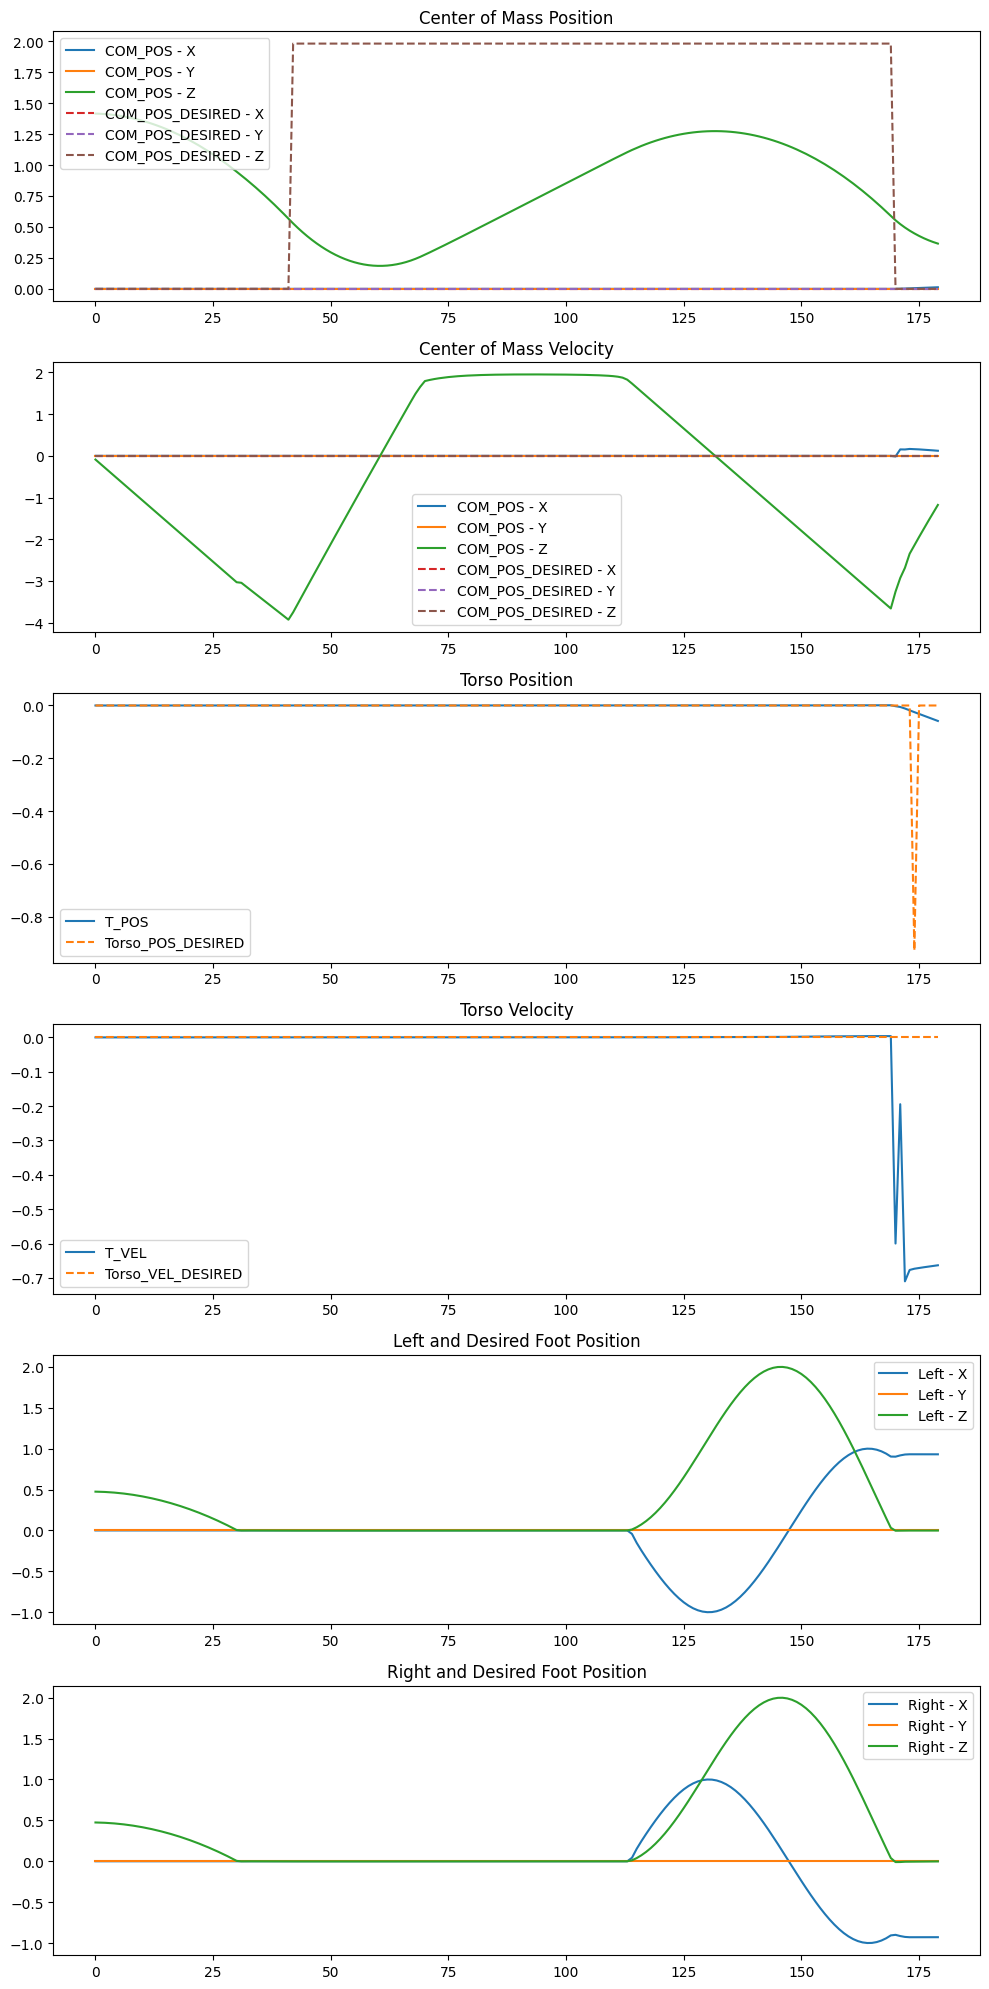

In [6]:
import matplotlib.pyplot as plt
import numpy as np


# Function to create subplots for 3D data
def plot_3d_data(ax, data, label, linestyle='-'):
    ax.plot(data[0, :], label=f'{label} - X', linestyle=linestyle)
    ax.plot(data[1, :], label=f'{label} - Y', linestyle=linestyle)
    ax.plot(data[2, :], label=f'{label} - Z', linestyle=linestyle)

# Create subplots
fig, axs = plt.subplots(6, 1, figsize=(10, 20))

# Plotting each pair of actual and desired values
plot_3d_data(axs[0], COM_POS, 'COM_POS')
plot_3d_data(axs[0], COM_POS_DESIRED, 'COM_POS_DESIRED', '--')
axs[0].set_title('Center of Mass Position')
axs[0].legend()

plot_3d_data(axs[1], COM_VEL, 'COM_POS')
plot_3d_data(axs[1], COM_VEL_DESIRED, 'COM_POS_DESIRED', '--')
axs[1].set_title('Center of Mass Velocity')
axs[1].legend()

axs[2].plot(T_POS[0], label = 'T_POS')
axs[2].plot(Torso_POS_DESIRED[0], label='Torso_POS_DESIRED', linestyle='--')
axs[2].set_title('Torso Position')
axs[2].legend()

axs[3].plot(T_VEL[0], label='T_VEL')
axs[3].plot(Torso_VEL_DESIRED[0], label='Torso_VEL_DESIRED', linestyle='--')
axs[3].set_title('Torso Velocity')
axs[3].legend()

plot_3d_data(axs[4], left, 'Left')
# plot_3d_data(axs[4], Ft_POS_DESIRED, 'Ft_POS_DESIRED', '--')
axs[4].set_title('Left and Desired Foot Position')
axs[4].legend()

plot_3d_data(axs[5], right, 'Right')
# plot_3d_data(axs[5], Ft_POS_DESIRED, 'Ft_POS_DESIRED', '--')
axs[5].set_title('Right and Desired Foot Position')
axs[5].legend()

plt.tight_layout()
plt.show()
